In [1]:
import pandas as pd
import os
from google.colab import drive 
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

drive.mount('/content/drive', force_remount=True)
os.chdir('/content/drive/Shared drives/Financial Modeling and Testing/Project 1/')

Mounted at /content/drive


# Problem at Hand

We have clearly seen that CRSP/COMPUSTAT Merged’s bankruptcy indicator - Research Company Reason For Deletion (DLRSN==02) - is lacking. It routinely cites the reason for firms being delisted as a non-bankrupt code (DLRSN!=02) even though multiple other sources, such as Bloomberg and Audit Analytics, cite it as having entered bankruptcy. The figure below compares the varying bankruptcy indicators calculated thus far in the project as well as contrasting them to that found in the paper. It is clearly evident that DLRSN(02) falls short at capturing firms entering bankruptcy, especially post 1995. 

![](https://drive.google.com/uc?export=view&id=1-AAZjHp7OQ27x3fKNtb-6zNZ3kazjetp)


Although creating a combined bankruptcy indicator (ie if one source cites the firm as having entered bankruptcy, the combined indicator will signal the firm entered bankruptcy) is a viable solution to addressing the shortcomings of CRSP/COMPUSTAT Merged's bankruptcy indicator, an alternative approach is to attempt to reclassify possibly misclassified firms as determined by DLRSN by identifying a common characteristic that we would expect a vast majority of firms entering bankruptcy to exhibit and then reclassify all delisted firms that exhibit this characteristic prior to their delisting as having entered bankruptcy.

While there are many characteristics we would expect a firm entering or on the verge of bankruptcy to exhibit, an argument could be made that the simplest criteria would perform the most accurately across a wide range of firms and time periods. Therefore, we conjecture that classifying firms which are delisted and also see an extreme drop in their returns over a predetermined time period have likely undergone or are in the process of filing for or entering bankruptcy and should therefore be classified as such. In this report we will experiment with a variety of return drop thresholds and previous time horizon's to identify the best parameters for accurate bankruptcy reclassification.

# Read in Data

In [61]:
#df = pd.read_csv('Data/finalDataframe_wBankruptcyWithinIndicator.csv')
df = pd.read_csv('Data/testNEWDF.csv')

# Format Date Objects
df['date_month'] = pd.to_datetime(df['date_month']).dt.to_period('m')
df['last_date_existance'] = pd.to_datetime(df['last_date_existance']).dt.to_period('m')
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,index,Unnamed: 0.1,PERMNO,date_month,GVKEY,cik,conm,atq,ceqq,cheq,ltq,niq,dlrsn,dldte,PRC,RET,SHROUT,CFACPR,vwretdSP500,totvalSP500,NITA,NIMTA,TLTA,TLMTA,EXRET,RSIZE,CASHMTA,SIGMA,effectiveDate_Bloomberg_date_month,fileDate_AuditAnalytics_month,bankruptcyIndicator,bankruptcyDate,last_date_existance,bankruptFirm,bankruptcyWithin3Months,bankruptcyWithin6Months,bankruptcyWithin12Months,bankruptcyWithin24Months,bankruptcyWithin60Months,AdjPRC,RET2,logRET
0,0,0,0,10000,1986-02,13007.0,NaN,OPTIMUM MANUFACTURING -CL A,1.265,0.689,0.743,0.576,-0.132,10.0,1989-09-30,-3.25000,-0.257143,3680.0,1.0,0.076525,1.589623e+12,0.000110,0.000011,-0.000482,-0.000048,NaN,-7.523798e-09,-0.000062,NaN,NaN,NaN,0,1989-09,1987-05,0,0,0,0,0,0,NaN,0.0,0.0
1,1,1,1,10000,1986-03,13007.0,NaN,OPTIMUM MANUFACTURING -CL A,1.265,0.689,0.743,0.576,-0.132,10.0,1989-09-30,-4.43750,0.365385,3680.0,1.0,0.055832,1.671574e+12,0.000081,0.000008,-0.000353,-0.000035,0.495175,-9.769236e-09,-0.000046,NaN,NaN,NaN,0,1989-09,1987-05,0,0,0,0,0,0,NaN,0.0,0.0
2,2,2,2,10000,1986-04,13007.0,NaN,OPTIMUM MANUFACTURING -CL A,1.265,0.689,0.743,0.576,-0.132,10.0,1989-09-30,-4.00000,-0.098592,3793.0,1.0,-0.013348,1.642761e+12,0.000087,0.000009,-0.000380,-0.000038,0.759830,-9.235672e-09,-0.000049,NaN,NaN,NaN,0,1989-09,1987-05,0,0,0,0,0,0,NaN,0.0,0.0
3,3,3,3,10000,1986-05,13007.0,NaN,OPTIMUM MANUFACTURING -CL A,1.284,0.578,0.395,0.706,-0.484,10.0,1989-09-30,-3.10938,-0.222656,3793.0,1.0,0.055326,1.724749e+12,0.000411,0.000041,-0.000599,-0.000060,0.773142,-6.838025e-09,-0.000033,0.718449,NaN,NaN,0,1989-09,1987-05,0,0,0,0,0,0,NaN,0.0,0.0
4,4,4,4,10000,1986-06,13007.0,NaN,OPTIMUM MANUFACTURING -CL A,1.284,0.578,0.395,0.706,-0.484,10.0,1989-09-30,-3.09375,-0.005025,3793.0,1.0,0.015744,1.748550e+12,0.000413,0.000041,-0.000602,-0.000060,0.680049,-6.711042e-09,-0.000034,0.520684,NaN,NaN,0,1989-09,1987-05,0,0,0,0,0,0,NaN,0.0,0.0


# Calculate Avg Returns for Bankrupt Companies (Combined Indicator == 1) over specified time horizons

## Code

In [65]:
# Set Variables to Change
bankruptcyIndicator = 'bankruptcyIndicator'
bankruptcyIndicatorBoolValue = 1
returnType='RET2'
returnTypeName='Return'
retTimeHorizons = [1, 2, 3, 4]

# Copy Dataframe
dfTest = df.copy()

# Keep only specified columns
columnsToKeep = ['PERMNO', 'date_month', 'last_date_existance']
columnsToKeep.extend([returnType, bankruptcyIndicator])
dfTest = dfTest[columnsToKeep]

# Subset data to contain only bankrupt firms
bankruptFirms = list(dfTest[dfTest[bankruptcyIndicator]==bankruptcyIndicatorBoolValue]['PERMNO'].unique())
dfTest = dfTest[dfTest['PERMNO'].isin(bankruptFirms)]

# Subset DF to Random Subset of PERMNOs that went bankrupt (for testing purposes only)
#random.seed(42)
#dfTest = dfTest[dfTest['PERMNO'].isin(random.sample(list(dfTest['PERMNO'].unique()), 5))]


# Calculate Avg Return for Every PERMNO over specified time horizons
for retTimeHorizon in retTimeHorizons:
  rollingMean = dfTest.sort_values(
      ['PERMNO', 'date_month'], ascending=True
      ).groupby(
          ['PERMNO']
          )[
            ['date_month', returnType]
            ].rolling(
                retTimeHorizon, on='date_month'
            ).mean().reset_index().drop(columns=['level_1']).rename(columns={returnType: f'Avg{returnTypeName}_prev{retTimeHorizon}months'})


  dfTest = pd.merge(dfTest,
                    rollingMean,
                    how='inner',
                    left_on=['PERMNO', 'date_month'],
                    right_on=['PERMNO', 'date_month']
                    )

# Keep only last date of firms existance
dfTest = dfTest[dfTest['date_month']==dfTest['last_date_existance']]

dfTest.head()

,PERMNO,date_month,last_date_existance,RET2,bankruptcyIndicator,AvgReturn_prev1months,AvgReturn_prev2months,AvgReturn_prev3months,AvgReturn_prev4months
182,10039,2001-05,2001-05,-0.230769,1,-0.230769,-0.454432,-0.474438,-0.407434
288,10047,1994-12,1994-12,-0.076923,1,-0.076923,-0.074176,-0.091117,-0.068338
451,10048,1999-09,1999-09,-0.021448,1,-0.021448,0.012785,-0.002120,-0.035627
501,10076,1990-05,1990-05,0.000000,1,0.000000,0.000000,0.000000,0.000000
712,10080,2003-10,2003-10,-0.230487,1,-0.230487,-0.160410,-0.106940,-0.099436


## Function

In [66]:
def calculateAvgRetOverTimePeriod(dfTest,
                                  bankruptcyIndicator, 
                                  bankruptcyIndicatorBoolValue,
                                  returnType,
                                  returnTypeName,
                                  retTimeHorizons
                                  ):
  # Keep only specified columns
  columnsToKeep = ['PERMNO', 'date_month', 'last_date_existance']
  columnsToKeep.extend([returnType, bankruptcyIndicator])
  dfTest = dfTest[columnsToKeep]

  # Subset data to contain only bankrupt firms
  bankruptFirms = list(dfTest[dfTest[bankruptcyIndicator]==bankruptcyIndicatorBoolValue]['PERMNO'].unique())
  dfTest = dfTest[dfTest['PERMNO'].isin(bankruptFirms)]

  # Subset DF to Random Subset of PERMNOs that went bankrupt (for testing purposes only)
  #random.seed(42)
  #dfTest = dfTest[dfTest['PERMNO'].isin(random.sample(list(dfTest['PERMNO'].unique()), 5))]


  # Calculate Avg Return for Every PERMNO over specified time horizons
  for retTimeHorizon in retTimeHorizons:
    rollingMean = dfTest.sort_values(
        ['PERMNO', 'date_month'], ascending=True
        ).groupby(
            ['PERMNO']
            )[
              ['date_month', returnType]
              ].rolling(
                  retTimeHorizon, on='date_month'
              ).mean().reset_index().drop(columns=['level_1']).rename(columns={returnType: f'Avg{returnTypeName}_prev{retTimeHorizon}months'})


    dfTest = pd.merge(dfTest,
                      rollingMean,
                      how='inner',
                      left_on=['PERMNO', 'date_month'],
                      right_on=['PERMNO', 'date_month']
                      )

  # Keep only last date of firms existance
  dfTest = dfTest[dfTest['date_month']==dfTest['last_date_existance']]

  return dfTest

# Set Variables to Change
bankruptcyIndicator = 'bankruptcyIndicator'
bankruptcyIndicatorBoolValue = 1
returnType='RET2'
returnTypeName='Return'
retTimeHorizons = [1, 2, 3, 4]

# Copy Dataframe
dfTest = df.copy()

dfTest = calculateAvgRetOverTimePeriod(dfTest,
                                bankruptcyIndicator, 
                                bankruptcyIndicatorBoolValue,
                                returnType,
                                returnTypeName,
                                retTimeHorizons
                                )

dfTest.head()

,PERMNO,date_month,last_date_existance,RET2,bankruptcyIndicator,AvgReturn_prev1months,AvgReturn_prev2months,AvgReturn_prev3months,AvgReturn_prev4months
182,10039,2001-05,2001-05,-0.230769,1,-0.230769,-0.454432,-0.474438,-0.407434
288,10047,1994-12,1994-12,-0.076923,1,-0.076923,-0.074176,-0.091117,-0.068338
451,10048,1999-09,1999-09,-0.021448,1,-0.021448,0.012785,-0.002120,-0.035627
501,10076,1990-05,1990-05,0.000000,1,0.000000,0.000000,0.000000,0.000000
712,10080,2003-10,2003-10,-0.230487,1,-0.230487,-0.160410,-0.106940,-0.099436


## Plotting

### Average Return - Previous 1 Month

#### Code

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


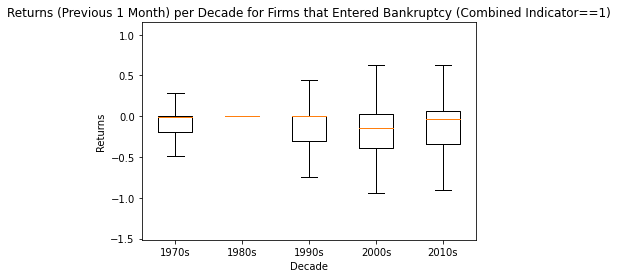

Decade: 1970s
Number of Firms:  39
Minimum:  -0.4903846153846154
1st Quantile:  -0.19615384615384615
Median (2nd Quantile):  -0.01433691756272404
3rd Quantile:  0.0
Maximum:  0.29423076923076924


Decade: 1980s
Number of Firms:  139
Minimum:  0.0
1st Quantile:  0.0
Median (2nd Quantile):  0.0
3rd Quantile:  0.0
Maximum:  0.0


Decade: 1990s
Number of Firms:  443
Minimum:  -0.7500000000000001
1st Quantile:  -0.30000000000000004
Median (2nd Quantile):  0.0
3rd Quantile:  0.0
Maximum:  0.45000000000000007


Decade: 2000s
Number of Firms:  850
Minimum:  -1.0150298570222982
1st Quantile:  -0.3928571428571429
Median (2nd Quantile):  -0.14701183987972194
3rd Quantile:  0.021924666586293995
Maximum:  0.6440973807514494


Decade: 2010s
Number of Firms:  396
Minimum:  -0.9262242243495706
1st Quantile:  -0.33476696480594914
Median (2nd Quantile):  -0.03433107199684576
3rd Quantile:  0.0595378748897985
Maximum:  0.6509951344334199




In [64]:
# Set Variables to Change
# Time Period Cuts
cut_labels = ['1970s', '1980s', '1990s', '2000s', '2010s']
cut_bins = [1970, 1979, 1989, 1999, 2009, 2019]
cut_column_label = 'Decade'

# Return
returnName='AvgReturn_prev1months'
returnTypeName='Returns'
bankruptcyIndicatorNameValue = 'Combined Indicator==1'

# Plot
plotTitle = f'{returnTypeName} (Previous 1 Month) per {cut_column_label} for Firms that Entered Bankruptcy ({bankruptcyIndicatorNameValue})'

# Results
printResultsBool=True

# Copy DataFrame
bankruptFirmsPrevReturnsAnalysis = dfTest.copy()

# Convert Month Field to Year (int)
bankruptFirmsPrevReturnsAnalysis['year'] = bankruptFirmsPrevReturnsAnalysis['date_month'].map(lambda x: int(str(x)[:4]))

bankruptFirmsPrevReturnsAnalysis[cut_column_label] = pd.cut(bankruptFirmsPrevReturnsAnalysis['year'], bins=cut_bins, labels=cut_labels)

tempStorage=[]
for timePeriod in cut_labels:
  timePeriodData = bankruptFirmsPrevReturnsAnalysis[bankruptFirmsPrevReturnsAnalysis[cut_column_label]==timePeriod][returnName].values
  tempStorage.append(timePeriodData)

yMax=0
yMin=0
for i, timePeriod in enumerate(cut_labels):
  q1 = pd.Series(tempStorage[i]).quantile(.25)
  q3 = pd.Series(tempStorage[i]).quantile(.75)
  min = q1 - 1.5*(q3-q1)
  max = q3 + 1.5*(q3-q1)
  if min<yMin:
    yMin=min
  if max>yMax:
    yMax=max
yMax+=.5
yMin-=.5

fig, ax = plt.subplots()
ax.boxplot(tempStorage, sym='')
ax.set_ylim([yMin,yMax])
ax.set_xticklabels(cut_labels)
ax.set_xlabel(cut_column_label)
ax.set_ylabel(returnTypeName)
ax.set_title(plotTitle)

plt.show()

if printResultsBool:
  for i, timePeriod in enumerate(cut_labels):
    q1 = pd.Series(tempStorage[i]).quantile(.25)
    q2 = pd.Series(tempStorage[i]).quantile(.5)
    q3 = pd.Series(tempStorage[i]).quantile(.75)
    print(f'{cut_column_label}: {timePeriod}')
    print('Number of Firms: ', len(tempStorage[i]))
    print('Minimum: ', q1 - 1.5*(q3-q1))
    print('1st Quantile: ', q1)
    print('Median (2nd Quantile): ', q2)
    print('3rd Quantile: ', q3)
    print('Maximum: ', q3 + 1.5*(q3-q1))

    print('')
    print('')

#### Function

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


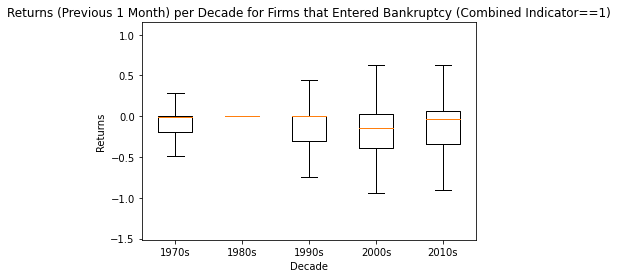

Decade: 1970s
Number of Firms:  39
Minimum:  -0.4903846153846154
1st Quantile:  -0.19615384615384615
Median (2nd Quantile):  -0.01433691756272404
3rd Quantile:  0.0
Maximum:  0.29423076923076924


Decade: 1980s
Number of Firms:  139
Minimum:  0.0
1st Quantile:  0.0
Median (2nd Quantile):  0.0
3rd Quantile:  0.0
Maximum:  0.0


Decade: 1990s
Number of Firms:  443
Minimum:  -0.7500000000000001
1st Quantile:  -0.30000000000000004
Median (2nd Quantile):  0.0
3rd Quantile:  0.0
Maximum:  0.45000000000000007


Decade: 2000s
Number of Firms:  850
Minimum:  -1.0150298570222982
1st Quantile:  -0.3928571428571429
Median (2nd Quantile):  -0.14701183987972194
3rd Quantile:  0.021924666586293995
Maximum:  0.6440973807514494


Decade: 2010s
Number of Firms:  396
Minimum:  -0.9262242243495706
1st Quantile:  -0.33476696480594914
Median (2nd Quantile):  -0.03433107199684576
3rd Quantile:  0.0595378748897985
Maximum:  0.6509951344334199




In [67]:
def plotReturns(bankruptFirmsPrevReturnsAnalysis,
                cut_labels,
                cut_bins,
                cut_column_label,
                returnName,
                returnTypeName,
                bankruptcyIndicatorNameValue,
                plotTitle,
                printResultsBool
                ):
  # Convert Month Field to Year (int)
  bankruptFirmsPrevReturnsAnalysis['year'] = bankruptFirmsPrevReturnsAnalysis['date_month'].map(lambda x: int(str(x)[:4]))

  bankruptFirmsPrevReturnsAnalysis[cut_column_label] = pd.cut(bankruptFirmsPrevReturnsAnalysis['year'], bins=cut_bins, labels=cut_labels)

  tempStorage=[]
  for timePeriod in cut_labels:
    timePeriodData = bankruptFirmsPrevReturnsAnalysis[bankruptFirmsPrevReturnsAnalysis[cut_column_label]==timePeriod][returnName].values
    tempStorage.append(timePeriodData)

  yMax=0
  yMin=0
  for i, timePeriod in enumerate(cut_labels):
    q1 = pd.Series(tempStorage[i]).quantile(.25)
    q3 = pd.Series(tempStorage[i]).quantile(.75)
    min = q1 - 1.5*(q3-q1)
    max = q3 + 1.5*(q3-q1)
    if min<yMin:
      yMin=min
    if max>yMax:
      yMax=max
  yMax+=.5
  yMin-=.5

  fig, ax = plt.subplots()
  ax.boxplot(tempStorage, sym='')
  ax.set_ylim([yMin,yMax])
  ax.set_xticklabels(cut_labels)
  ax.set_xlabel(cut_column_label)
  ax.set_ylabel(returnTypeName)
  ax.set_title(plotTitle)

  plt.show()

  if printResultsBool:
    for i, timePeriod in enumerate(cut_labels):
      q1 = pd.Series(tempStorage[i]).quantile(.25)
      q2 = pd.Series(tempStorage[i]).quantile(.5)
      q3 = pd.Series(tempStorage[i]).quantile(.75)
      print(f'{cut_column_label}: {timePeriod}')
      print('Number of Firms: ', len(tempStorage[i]))
      print('Minimum: ', q1 - 1.5*(q3-q1))
      print('1st Quantile: ', q1)
      print('Median (2nd Quantile): ', q2)
      print('3rd Quantile: ', q3)
      print('Maximum: ', q3 + 1.5*(q3-q1))

      print('')
      print('')

# Set Variables to Change
# Time Period Cuts
cut_labels = ['1970s', '1980s', '1990s', '2000s', '2010s']
cut_bins = [1970, 1979, 1989, 1999, 2009, 2019]
cut_column_label = 'Decade'

# Return
returnName='AvgReturn_prev1months'
returnTypeName='Returns'
bankruptcyIndicatorNameValue = 'Combined Indicator==1'

# Plot
plotTitle = f'{returnTypeName} (Previous 1 Month) per {cut_column_label} for Firms that Entered Bankruptcy ({bankruptcyIndicatorNameValue})'

# Results
printResultsBool=True

# Copy DataFrame
bankruptFirmsPrevReturnsAnalysis = dfTest.copy()

plotReturns(bankruptFirmsPrevReturnsAnalysis,
                cut_labels,
                cut_bins,
                cut_column_label,
                returnName,
                returnTypeName,
                bankruptcyIndicatorNameValue,
                plotTitle,
            printResultsBool
                )

### Average Return Pervious 2 Months

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


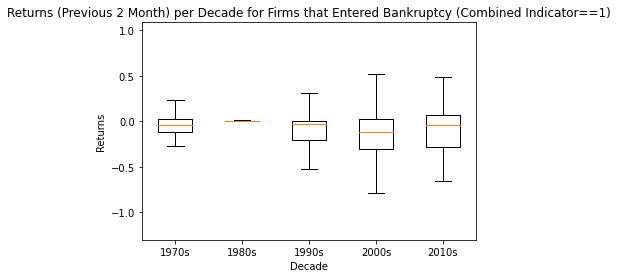

Decade: 1970s
Number of Firms:  39
Minimum:  -0.32801233396566076
1st Quantile:  -0.11238140417442702
Median (2nd Quantile):  -0.04420289855060706
3rd Quantile:  0.03137254901972883
Maximum:  0.2470034788109626


Decade: 1980s
Number of Firms:  139
Minimum:  -0.006969217491448194
1st Quantile:  9.520162436160717e-15
Median (2nd Quantile):  1.7774670624248756e-13
3rd Quantile:  0.004646144994314663
Maximum:  0.011615362485772378


Decade: 1990s
Number of Firms:  443
Minimum:  -0.5285454093950764
1st Quantile:  -0.20794025157223472
Median (2nd Quantile):  -0.03333333333326205
3rd Quantile:  0.005796520309659742
Maximum:  0.3264016781325014


Decade: 2000s
Number of Firms:  850
Minimum:  -0.8023490041047097
1st Quantile:  -0.30355683563692804
Median (2nd Quantile):  -0.11710802521238337
3rd Quantile:  0.02897127667492639
Maximum:  0.527763445142708


Decade: 2010s
Number of Firms:  396
Minimum:  -0.7966037490631344
1st Quantile:  -0.2768587870220098
Median (2nd Quantile):  -0.039126686211

In [69]:
# Set Variables to Change
# Time Period Cuts
cut_labels = ['1970s', '1980s', '1990s', '2000s', '2010s']
cut_bins = [1970, 1979, 1989, 1999, 2009, 2019]
cut_column_label = 'Decade'

# Return
returnName='AvgReturn_prev2months'
returnTypeName='Returns'
bankruptcyIndicatorNameValue = 'Combined Indicator==1'

# Plot
plotTitle = f'{returnTypeName} (Previous 2 Month) per {cut_column_label} for Firms that Entered Bankruptcy ({bankruptcyIndicatorNameValue})'

# Results
printResultsBool=True

# Copy DataFrame
bankruptFirmsPrevReturnsAnalysis = dfTest.copy()

plotReturns(bankruptFirmsPrevReturnsAnalysis,
                cut_labels,
                cut_bins,
                cut_column_label,
                returnName,
                returnTypeName,
                bankruptcyIndicatorNameValue,
                plotTitle,
            printResultsBool
                )

### Average Return Pervious 3 Months

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


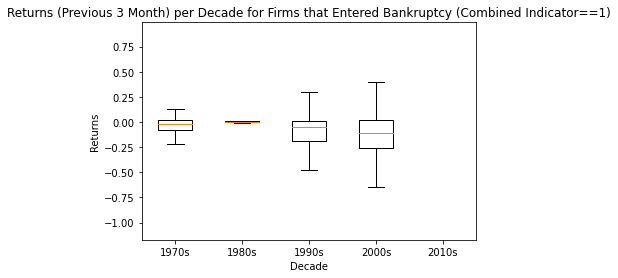

Decade: 1970s
Number of Firms:  39
Minimum:  -0.2254781778413482
1st Quantile:  -0.0810185185185173
Median (2nd Quantile):  -0.016666666666667124
3rd Quantile:  0.01528792103003664
Maximum:  0.15974758035286754


Decade: 1980s
Number of Firms:  139
Minimum:  -0.008946396491028038
1st Quantile:  9.25185853854297e-16
Median (2nd Quantile):  3.7231791723731554e-14
3rd Quantile:  0.005964264327353567
Maximum:  0.014910660818382531


Decade: 1990s
Number of Firms:  443
Minimum:  -0.48250413043077445
1st Quantile:  -0.18750677634495225
Median (2nd Quantile):  -0.04999999999959459
3rd Quantile:  0.009158126378929191
Maximum:  0.3041554804647514


Decade: 2000s
Number of Firms:  850
Minimum:  -0.6714893189267624
1st Quantile:  -0.2584718801309652
Median (2nd Quantile):  -0.10752251712708746
3rd Quantile:  0.01687307906623291
Maximum:  0.42989051786203014


Decade: 2010s
Number of Firms:  396
Minimum:  -0.6432192652312124
1st Quantile:  -0.21792575155507987
Median (2nd Quantile):  -0.0337534012

In [70]:
# Set Variables to Change
# Time Period Cuts
cut_labels = ['1970s', '1980s', '1990s', '2000s', '2010s']
cut_bins = [1970, 1979, 1989, 1999, 2009, 2019]
cut_column_label = 'Decade'

# Return
returnName='AvgReturn_prev3months'
returnTypeName='Returns'
bankruptcyIndicatorNameValue = 'Combined Indicator==1'

# Plot
plotTitle = f'{returnTypeName} (Previous 3 Month) per {cut_column_label} for Firms that Entered Bankruptcy ({bankruptcyIndicatorNameValue})'

# Results
printResultsBool=True

# Copy DataFrame
bankruptFirmsPrevReturnsAnalysis = dfTest.copy()

plotReturns(bankruptFirmsPrevReturnsAnalysis,
                cut_labels,
                cut_bins,
                cut_column_label,
                returnName,
                returnTypeName,
                bankruptcyIndicatorNameValue,
                plotTitle,
            printResultsBool
                )

### Average Return Pervious 4 Months

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


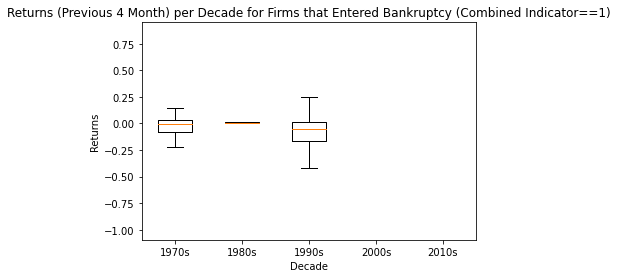

Decade: 1970s
Number of Firms:  39
Minimum:  -0.24389954769105915
1st Quantile:  -0.07874357002626109
Median (2nd Quantile):  -0.003571428571216992
3rd Quantile:  0.03136041508360428
Maximum:  0.19651639274840232


Decade: 1980s
Number of Firms:  139
Minimum:  -0.014263652910969631
1st Quantile:  0.0
Median (2nd Quantile):  2.142730437526552e-13
3rd Quantile:  0.00950910194064642
Maximum:  0.023772754851616052


Decade: 1990s
Number of Firms:  443
Minimum:  -0.4252040869237196
1st Quantile:  -0.16332326596506175
Median (2nd Quantile):  -0.048638769135870855
3rd Quantile:  0.011263948007376803
Maximum:  0.2731447689660346


Decade: 2000s
Number of Firms:  850
Minimum:  -0.5825472054988403
1st Quantile:  -0.22700636546410846
Median (2nd Quantile):  -0.10010134948732238
3rd Quantile:  0.01002086122571276
Maximum:  0.3655617012604446


Decade: 2010s
Number of Firms:  396
Minimum:  -0.595020951163836
1st Quantile:  -0.20263810492601458
Median (2nd Quantile):  -0.03191801214938629
3rd Quanti

In [71]:
# Set Variables to Change
# Time Period Cuts
cut_labels = ['1970s', '1980s', '1990s', '2000s', '2010s']
cut_bins = [1970, 1979, 1989, 1999, 2009, 2019]
cut_column_label = 'Decade'

# Return
returnName='AvgReturn_prev4months'
returnTypeName='Returns'
bankruptcyIndicatorNameValue = 'Combined Indicator==1'

# Plot
plotTitle = f'{returnTypeName} (Previous 4 Month) per {cut_column_label} for Firms that Entered Bankruptcy ({bankruptcyIndicatorNameValue})'

# Results
printResultsBool=True

# Copy DataFrame
bankruptFirmsPrevReturnsAnalysis = dfTest.copy()

plotReturns(bankruptFirmsPrevReturnsAnalysis,
                cut_labels,
                cut_bins,
                cut_column_label,
                returnName,
                returnTypeName,
                bankruptcyIndicatorNameValue,
                plotTitle,
            printResultsBool
                )

# Calculate Avg Returns for Bankrupt Companies (DLRSN == 2) over specified time horizons

## Code

In [72]:
# Set Variables to Change
bankruptcyIndicator = 'dlrsn'
bankruptcyIndicatorBoolValue = 2
returnType='RET2'
returnTypeName='Return'
retTimeHorizons = [1, 2, 3, 4]

# Copy Dataframe
dfTest = df.copy()

dfTest = calculateAvgRetOverTimePeriod(dfTest,
                                bankruptcyIndicator, 
                                bankruptcyIndicatorBoolValue,
                                returnType,
                                returnTypeName,
                                retTimeHorizons
                                )

dfTest = dfTest.dropna(subset=['dlrsn'])
dfTest.head()

,PERMNO,date_month,last_date_existance,RET2,dlrsn,AvgReturn_prev1months,AvgReturn_prev2months,AvgReturn_prev3months,AvgReturn_prev4months
49,10076,1990-05,1990-05,0.000000,2.0,0.000000,0.000000,0.000000,0.000000
64,10099,1987-06,1987-06,0.000000,2.0,0.000000,0.000000,0.000000,0.000000
186,10141,1996-06,1996-06,-0.058824,2.0,-0.058824,-0.202489,-0.284904,-0.182428
429,10222,1996-01,1996-01,0.333333,2.0,0.333333,0.166667,-0.079365,-0.222024
460,10264,1989-02,1989-02,0.000000,2.0,0.000000,0.000000,0.000000,0.000000


## Plotting

### Average Return Pervious 1 Months

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


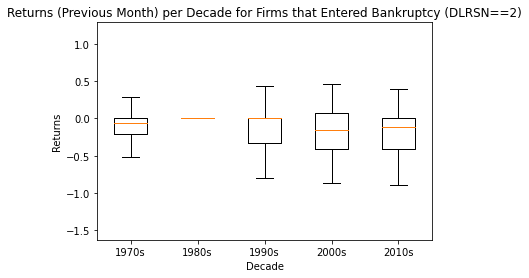

Decade: 1970s
Number of Firms:  35
Minimum:  -0.5384615384615385
1st Quantile:  -0.2153846153846154
Median (2nd Quantile):  -0.06666666666666665
3rd Quantile:  0.0
Maximum:  0.3230769230769231


Decade: 1980s
Number of Firms:  98
Minimum:  0.0
1st Quantile:  0.0
Median (2nd Quantile):  0.0
3rd Quantile:  0.0
Maximum:  0.0


Decade: 1990s
Number of Firms:  193
Minimum:  -0.8333333333333334
1st Quantile:  -0.33333333333333337
Median (2nd Quantile):  0.0
3rd Quantile:  0.0
Maximum:  0.5


Decade: 2000s
Number of Firms:  55
Minimum:  -1.1288768163377934
1st Quantile:  -0.40933191940615066
Median (2nd Quantile):  -0.15230769230769226
3rd Quantile:  0.07036467854827788
Maximum:  0.7899095754799207


Decade: 2010s
Number of Firms:  56
Minimum:  -1.0182054563448153
1st Quantile:  -0.40398949961109676
Median (2nd Quantile):  -0.10866922441779109
3rd Quantile:  0.005487804878048841
Maximum:  0.6197037616117673




In [74]:
# Set Variables to Change
# Time Period Cuts
cut_labels = ['1970s', '1980s', '1990s', '2000s', '2010s']
cut_bins = [1970, 1979, 1989, 1999, 2009, 2019]
cut_column_label = 'Decade'

# Return
returnName='AvgReturn_prev1months'
returnTypeName='Returns'
bankruptcyIndicatorNameValue = 'DLRSN==2'

# Plot
plotTitle = f'{returnTypeName} (Previous Month) per {cut_column_label} for Firms that Entered Bankruptcy ({bankruptcyIndicatorNameValue})'

# Results
printResultsBool=True

# Copy DataFrame
bankruptFirmsPrevReturnsAnalysis = dfTest.copy()

plotReturns(bankruptFirmsPrevReturnsAnalysis,
                cut_labels,
                cut_bins,
                cut_column_label,
                returnName,
                returnTypeName,
                bankruptcyIndicatorNameValue,
                plotTitle,
            printResultsBool
                )

### Average Return Pervious 2

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


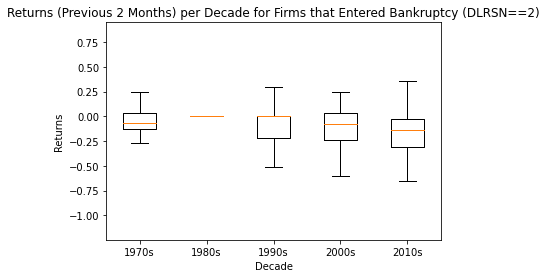

Decade: 1970s
Number of Firms:  35
Minimum:  -0.3592623339659152
1st Quantile:  -0.12488140417460024
Median (2nd Quantile):  -0.06250000000005551
3rd Quantile:  0.03137254901960973
Maximum:  0.2657534788109247


Decade: 1980s
Number of Firms:  98
Minimum:  -3.2167627936341425e-13
1st Quantile:  0.0
Median (2nd Quantile):  3.635980405647388e-15
3rd Quantile:  2.1445085290894284e-13
Maximum:  5.361271322723571e-13


Decade: 1990s
Number of Firms:  193
Minimum:  -0.539446185997694
1st Quantile:  -0.2157784743989493
Median (2nd Quantile):  0.0
3rd Quantile:  2.138844656940364e-13
Maximum:  0.32366771159895863


Decade: 2000s
Number of Firms:  55
Minimum:  -0.6511111331580979
1st Quantile:  -0.23839869281023263
Median (2nd Quantile):  -0.08242753623166703
3rd Quantile:  0.03674293408834415
Maximum:  0.44945537443620937


Decade: 2010s
Number of Firms:  56
Minimum:  -0.7472991301100962
1st Quantile:  -0.31256944837821804
Median (2nd Quantile):  -0.13946253436022232
3rd Quantile:  -0.02274966

In [76]:
# Set Variables to Change
# Time Period Cuts
cut_labels = ['1970s', '1980s', '1990s', '2000s', '2010s']
cut_bins = [1970, 1979, 1989, 1999, 2009, 2019]
cut_column_label = 'Decade'

# Return
returnName='AvgReturn_prev2months'
returnTypeName='Returns'
bankruptcyIndicatorNameValue = 'DLRSN==2'

# Plot
plotTitle = f'{returnTypeName} (Previous 2 Months) per {cut_column_label} for Firms that Entered Bankruptcy ({bankruptcyIndicatorNameValue})'

# Results
printResultsBool=True

# Copy DataFrame
bankruptFirmsPrevReturnsAnalysis = dfTest.copy()

plotReturns(bankruptFirmsPrevReturnsAnalysis,
                cut_labels,
                cut_bins,
                cut_column_label,
                returnName,
                returnTypeName,
                bankruptcyIndicatorNameValue,
                plotTitle,
            printResultsBool
                )

### Average Return Pervious 3

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


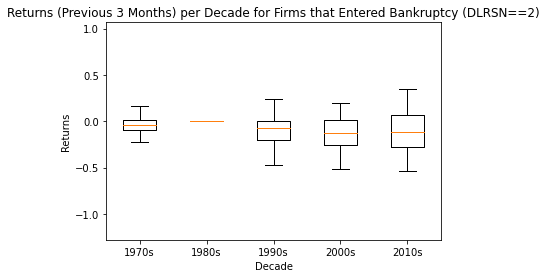

Decade: 1970s
Number of Firms:  35
Minimum:  -0.24739473886931154
1st Quantile:  -0.09003978779850036
Median (2nd Quantile):  -0.035573122529714396
3rd Quantile:  0.014863512915373755
Maximum:  0.17221846398618493


Decade: 1980s
Number of Firms:  98
Minimum:  -8.770761894538737e-15
1st Quantile:  0.0
Median (2nd Quantile):  0.0
3rd Quantile:  5.8471745963591575e-15
Maximum:  1.4617936490897893e-14


Decade: 1990s
Number of Firms:  193
Minimum:  -0.5104617604620447
1st Quantile:  -0.2041847041848179
Median (2nd Quantile):  -0.07056159420289275
3rd Quantile:  0.0
Maximum:  0.30627705627722684


Decade: 2000s
Number of Firms:  55
Minimum:  -0.6537674506723812
1st Quantile:  -0.25367777568974204
Median (2nd Quantile):  -0.12391720806276596
3rd Quantile:  0.013048674298684077
Maximum:  0.4131383492813232


Decade: 2010s
Number of Firms:  56
Minimum:  -0.7799378244326358
1st Quantile:  -0.2745638643781311
Median (2nd Quantile):  -0.11999499569948643
3rd Quantile:  0.062352108991538785
Maxim

In [77]:
# Set Variables to Change
# Time Period Cuts
cut_labels = ['1970s', '1980s', '1990s', '2000s', '2010s']
cut_bins = [1970, 1979, 1989, 1999, 2009, 2019]
cut_column_label = 'Decade'

# Return
returnName='AvgReturn_prev3months'
returnTypeName='Returns'
bankruptcyIndicatorNameValue = 'DLRSN==2'

# Plot
plotTitle = f'{returnTypeName} (Previous 3 Months) per {cut_column_label} for Firms that Entered Bankruptcy ({bankruptcyIndicatorNameValue})'

# Results
printResultsBool=True

# Copy DataFrame
bankruptFirmsPrevReturnsAnalysis = dfTest.copy()

plotReturns(bankruptFirmsPrevReturnsAnalysis,
                cut_labels,
                cut_bins,
                cut_column_label,
                returnName,
                returnTypeName,
                bankruptcyIndicatorNameValue,
                plotTitle,
            printResultsBool
                )

### Average Return Pervious 4

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


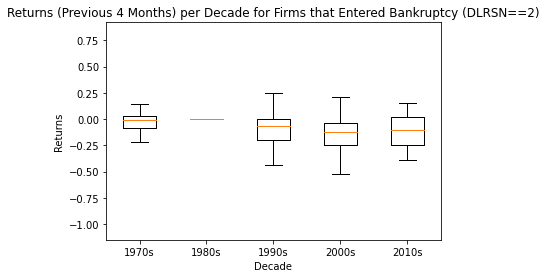

Decade: 1970s
Number of Firms:  35
Minimum:  -0.26089267276742717
1st Quantile:  -0.08879573230382024
Median (2nd Quantile):  -0.0125000000000004
3rd Quantile:  0.02593556133858439
Maximum:  0.1980325018021913


Decade: 1980s
Number of Firms:  98
Minimum:  -1.979458263967615e-13
1st Quantile:  0.0
Median (2nd Quantile):  2.4119595209981526e-14
3rd Quantile:  1.3196388426450767e-13
Maximum:  3.2990971066126917e-13


Decade: 1990s
Number of Firms:  193
Minimum:  -0.491319444444403
1st Quantile:  -0.19652777777773642
Median (2nd Quantile):  -0.06304372710609574
3rd Quantile:  4.13245826447195e-14
Maximum:  0.2947916666667079


Decade: 2000s
Number of Firms:  55
Minimum:  -0.5584648403990717
1st Quantile:  -0.24511635684978383
Median (2nd Quantile):  -0.12207101251584435
3rd Quantile:  -0.03621736781692518
Maximum:  0.27713111573236276


Decade: 2010s
Number of Firms:  56
Minimum:  -0.6506672480730976
1st Quantile:  -0.24857386891741562
Median (2nd Quantile):  -0.10228888136891744
3rd Quan

In [78]:
# Set Variables to Change
# Time Period Cuts
cut_labels = ['1970s', '1980s', '1990s', '2000s', '2010s']
cut_bins = [1970, 1979, 1989, 1999, 2009, 2019]
cut_column_label = 'Decade'

# Return
returnName='AvgReturn_prev4months'
returnTypeName='Returns'
bankruptcyIndicatorNameValue = 'DLRSN==2'

# Plot
plotTitle = f'{returnTypeName} (Previous 4 Months) per {cut_column_label} for Firms that Entered Bankruptcy ({bankruptcyIndicatorNameValue})'

# Results
printResultsBool=True

# Copy DataFrame
bankruptFirmsPrevReturnsAnalysis = dfTest.copy()

plotReturns(bankruptFirmsPrevReturnsAnalysis,
                cut_labels,
                cut_bins,
                cut_column_label,
                returnName,
                returnTypeName,
                bankruptcyIndicatorNameValue,
                plotTitle,
            printResultsBool
                )

# Calculate Avg Returns for Non-Bankrupt Companies but underwent Bankrupty (DLRSN != 2) over specified time horizons

## Code

In [52]:
# Set Variables to Change
bankruptcyIndicator = 'dlrsn'
bankruptcyIndicatorBoolValue=2
returnType='RET2'
returnTypeName='Return'
retTimeHorizons = [1, 2, 3, 4]

# Copy Dataframe
dfTest = df.copy()

# Drop firms who were not delisted
dfTest = dfTest.dropna(subset=['dlrsn'])

# Keep only specified columns
columnsToKeep = ['PERMNO', 'date_month', 'last_date_existance']
columnsToKeep.extend([returnType, bankruptcyIndicator])
dfTest = dfTest[columnsToKeep]

# Subset data to contain only bankrupt firms
bankruptFirms = list(dfTest[dfTest[bankruptcyIndicator]!=bankruptcyIndicatorBoolValue]['PERMNO'].unique())
dfTest = dfTest[dfTest['PERMNO'].isin(bankruptFirms)]

# Subset DF to Random Subset of PERMNOs that went bankrupt (for testing purposes only)
#random.seed(42)
#dfTest = dfTest[dfTest['PERMNO'].isin(random.sample(list(dfTest['PERMNO'].unique()), 5))]


# Calculate Avg Return for Every PERMNO over specified time horizons
for retTimeHorizon in retTimeHorizons:
  rollingMean = dfTest.sort_values(
      ['PERMNO', 'date_month'], ascending=True
      ).groupby(
          ['PERMNO']
          )[
            ['date_month', returnType]
            ].rolling(
                retTimeHorizon, on='date_month'
            ).mean().reset_index().drop(columns=['level_1']).rename(columns={returnType: f'Avg{returnTypeName}_prev{retTimeHorizon}months'})


  dfTest = pd.merge(dfTest,
                    rollingMean,
                    how='inner',
                    left_on=['PERMNO', 'date_month'],
                    right_on=['PERMNO', 'date_month']
                    )

# Keep only last date of firms existance
dfTest = dfTest[dfTest['date_month']==dfTest['last_date_existance']]

dfTest.head()

,PERMNO,date_month,last_date_existance,RET2,dlrsn,AvgReturn_prev1months,AvgReturn_prev2months,AvgReturn_prev3months,AvgReturn_prev4months
15,10000,1987-05,1987-05,0.000000,10.0,0.000000,0.000000,0.000000e+00,0.000000
387,10001,2017-07,2017-07,0.001934,1.0,0.001934,0.009825,1.188359e-02,0.004976
449,10005,1991-06,1991-06,0.000000,10.0,0.000000,0.000000,7.401487e-17,0.000000
515,10008,1988-10,1988-10,0.290698,1.0,0.290698,0.211138,1.322119e-01,0.131768
629,10010,1995-07,1995-07,0.091667,1.0,0.091667,0.063075,4.789776e-02,0.245601


## Plotting

### Average Return Pervious 1 Months

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


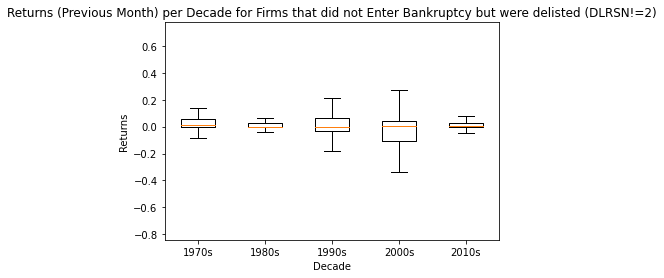

In [53]:
# Set Variables to Change
# Time Period Cuts
cut_labels = ['1970s', '1980s', '1990s', '2000s', '2010s']
cut_bins = [1970, 1979, 1989, 1999, 2009, 2019]
cut_column_label = 'Decade'

# Return
returnName='AvgReturn_prev1months'
returnTypeName='Returns'
bankruptcyIndicatorNameValue = 'DLRSN!=2'

# Plot
plotTitle = f'{returnTypeName} (Previous Month) per {cut_column_label} for Firms that did not Enter Bankruptcy but were delisted ({bankruptcyIndicatorNameValue})'

# Results
printResultsBool=False

# Copy DataFrame
bankruptFirmsPrevReturnsAnalysis = dfTest.copy()

plotReturns(bankruptFirmsPrevReturnsAnalysis,
                cut_labels,
                cut_bins,
                cut_column_label,
                returnName,
                returnTypeName,
                bankruptcyIndicatorNameValue,
                plotTitle,
            printResultsBool
                )

### Average Return Pervious 2 Months

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


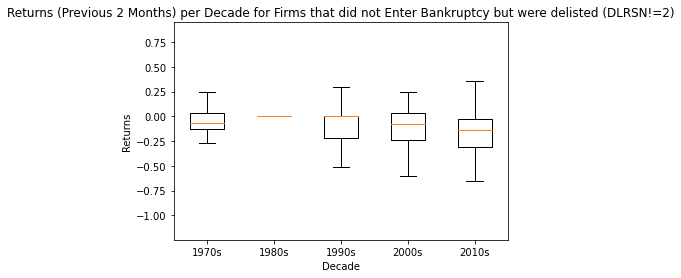

In [79]:
# Set Variables to Change
# Time Period Cuts
cut_labels = ['1970s', '1980s', '1990s', '2000s', '2010s']
cut_bins = [1970, 1979, 1989, 1999, 2009, 2019]
cut_column_label = 'Decade'

# Return
returnName='AvgReturn_prev2months'
returnTypeName='Returns'
bankruptcyIndicatorNameValue = 'DLRSN!=2'

# Plot
plotTitle = f'{returnTypeName} (Previous 2 Months) per {cut_column_label} for Firms that did not Enter Bankruptcy but were delisted ({bankruptcyIndicatorNameValue})'

# Results
printResultsBool=False

# Copy DataFrame
bankruptFirmsPrevReturnsAnalysis = dfTest.copy()

plotReturns(bankruptFirmsPrevReturnsAnalysis,
                cut_labels,
                cut_bins,
                cut_column_label,
                returnName,
                returnTypeName,
                bankruptcyIndicatorNameValue,
                plotTitle,
            printResultsBool
                )

### Average Return Pervious 3 Months

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


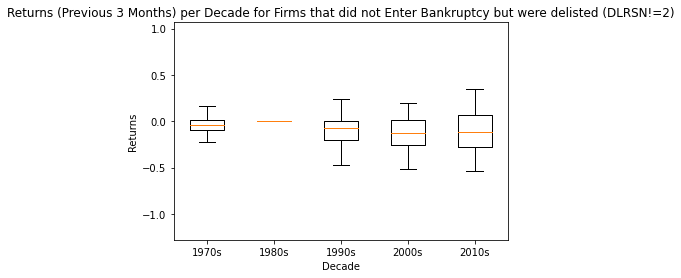

In [80]:
# Set Variables to Change
# Time Period Cuts
cut_labels = ['1970s', '1980s', '1990s', '2000s', '2010s']
cut_bins = [1970, 1979, 1989, 1999, 2009, 2019]
cut_column_label = 'Decade'

# Return
returnName='AvgReturn_prev3months'
returnTypeName='Returns'
bankruptcyIndicatorNameValue = 'DLRSN!=2'

# Plot
plotTitle = f'{returnTypeName} (Previous 3 Months) per {cut_column_label} for Firms that did not Enter Bankruptcy but were delisted ({bankruptcyIndicatorNameValue})'

# Results
printResultsBool=False

# Copy DataFrame
bankruptFirmsPrevReturnsAnalysis = dfTest.copy()

plotReturns(bankruptFirmsPrevReturnsAnalysis,
                cut_labels,
                cut_bins,
                cut_column_label,
                returnName,
                returnTypeName,
                bankruptcyIndicatorNameValue,
                plotTitle,
            printResultsBool
                )

### Average Return Pervious 4 Months

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


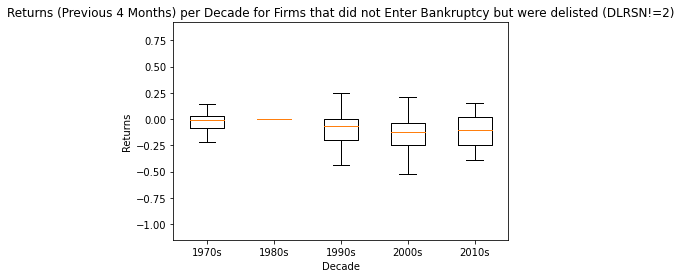

In [81]:
# Set Variables to Change
# Time Period Cuts
cut_labels = ['1970s', '1980s', '1990s', '2000s', '2010s']
cut_bins = [1970, 1979, 1989, 1999, 2009, 2019]
cut_column_label = 'Decade'

# Return
returnName='AvgReturn_prev4months'
returnTypeName='Returns'
bankruptcyIndicatorNameValue = 'DLRSN!=2'

# Plot
plotTitle = f'{returnTypeName} (Previous 4 Months) per {cut_column_label} for Firms that did not Enter Bankruptcy but were delisted ({bankruptcyIndicatorNameValue})'

# Results
printResultsBool=False

# Copy DataFrame
bankruptFirmsPrevReturnsAnalysis = dfTest.copy()

plotReturns(bankruptFirmsPrevReturnsAnalysis,
                cut_labels,
                cut_bins,
                cut_column_label,
                returnName,
                returnTypeName,
                bankruptcyIndicatorNameValue,
                plotTitle,
            printResultsBool
                )

# Calculate Avg Returns for Non-Bankrupt Companies but underwent delisting (Combined Indicator == 0 and DLRSN!=NaN) over specified time horizons

## Code

In [57]:
# Set Variables to Change
bankruptcyIndicator = 'bankruptcyIndicator'
bankruptcyIndicatorBoolValue=0
returnType='RET2'
returnTypeName='Return'
retTimeHorizons = [1, 2, 3, 4]

# Copy Dataframe
dfTest = df.copy()

# Drop firms who were not delisted
dfTest = dfTest.dropna(subset=['dlrsn'])

# Keep only specified columns
columnsToKeep = ['PERMNO', 'date_month', 'last_date_existance']
columnsToKeep.extend([returnType, bankruptcyIndicator])
dfTest = dfTest[columnsToKeep]

# Subset data to contain only bankrupt firms
bankruptFirms = list(dfTest[dfTest[bankruptcyIndicator]==bankruptcyIndicatorBoolValue]['PERMNO'].unique())
dfTest = dfTest[dfTest['PERMNO'].isin(bankruptFirms)]

# Subset DF to Random Subset of PERMNOs that went bankrupt (for testing purposes only)
#random.seed(42)
#dfTest = dfTest[dfTest['PERMNO'].isin(random.sample(list(dfTest['PERMNO'].unique()), 5))]


# Calculate Avg Return for Every PERMNO over specified time horizons
for retTimeHorizon in retTimeHorizons:
  rollingMean = dfTest.sort_values(
      ['PERMNO', 'date_month'], ascending=True
      ).groupby(
          ['PERMNO']
          )[
            ['date_month', returnType]
            ].rolling(
                retTimeHorizon, on='date_month'
            ).mean().reset_index().drop(columns=['level_1']).rename(columns={returnType: f'Avg{returnTypeName}_prev{retTimeHorizon}months'})


  dfTest = pd.merge(dfTest,
                    rollingMean,
                    how='inner',
                    left_on=['PERMNO', 'date_month'],
                    right_on=['PERMNO', 'date_month']
                    )

# Keep only last date of firms existance
dfTest = dfTest[dfTest['date_month']==dfTest['last_date_existance']]

dfTest.head()

,PERMNO,date_month,last_date_existance,RET2,bankruptcyIndicator,AvgReturn_prev1months,AvgReturn_prev2months,AvgReturn_prev3months,AvgReturn_prev4months
15,10000,1987-05,1987-05,0.000000,0,0.000000,0.000000,0.000000e+00,0.000000
387,10001,2017-07,2017-07,0.001934,0,0.001934,0.009825,1.188359e-02,0.004976
449,10005,1991-06,1991-06,0.000000,0,0.000000,0.000000,7.401487e-17,0.000000
515,10008,1988-10,1988-10,0.290698,0,0.290698,0.211138,1.322119e-01,0.131768
629,10010,1995-07,1995-07,0.091667,0,0.091667,0.063075,4.789776e-02,0.245601


## Plotting

### Average Return Pervious Months Before Delisting

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


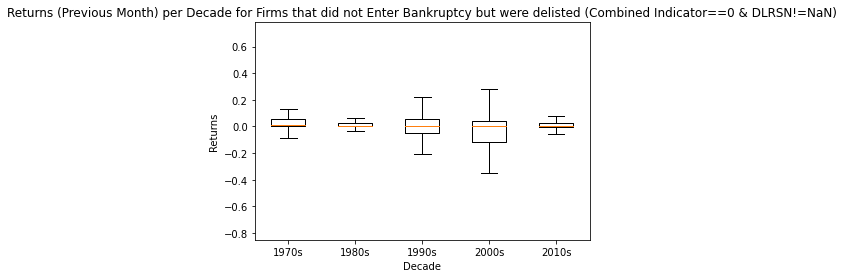

In [58]:
# Set Variables to Change
# Time Period Cuts
cut_labels = ['1970s', '1980s', '1990s', '2000s', '2010s']
cut_bins = [1970, 1979, 1989, 1999, 2009, 2019]
cut_column_label = 'Decade'

# Return
returnName='AvgReturn_prev1months'
returnTypeName='Returns'
bankruptcyIndicatorNameValue = 'Combined Indicator==0 & DLRSN!=NaN'

# Plot
plotTitle = f'{returnTypeName} (Previous Month) per {cut_column_label} for Firms that did not Enter Bankruptcy but were delisted ({bankruptcyIndicatorNameValue})'

# Results
printResultsBool=False

# Copy DataFrame
bankruptFirmsPrevReturnsAnalysis = dfTest.copy()

plotReturns(bankruptFirmsPrevReturnsAnalysis,
                cut_labels,
                cut_bins,
                cut_column_label,
                returnName,
                returnTypeName,
                bankruptcyIndicatorNameValue,
                plotTitle,
            printResultsBool
                )

### Average Return Pervious 2 Months Before Delisting

In [ ]:
# Set Variables to Change
# Time Period Cuts
cut_labels = ['1970s', '1980s', '1990s', '2000s', '2010s']
cut_bins = [1970, 1979, 1989, 1999, 2009, 2019]
cut_column_label = 'Decade'

# Return
returnName='AvgReturn_prev2months'
returnTypeName='Returns'
bankruptcyIndicatorNameValue = 'Combined Indicator==0 & DLRSN!=NaN'

# Plot
plotTitle = f'{returnTypeName} (Previous 2 Months) per {cut_column_label} for Firms that did not Enter Bankruptcy but were delisted ({bankruptcyIndicatorNameValue})'

# Results
printResultsBool=False

# Copy DataFrame
bankruptFirmsPrevReturnsAnalysis = dfTest.copy()

plotReturns(bankruptFirmsPrevReturnsAnalysis,
                cut_labels,
                cut_bins,
                cut_column_label,
                returnName,
                returnTypeName,
                bankruptcyIndicatorNameValue,
                plotTitle,
            printResultsBool
                )

### Average Return Pervious 3 Months Before Delisting

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


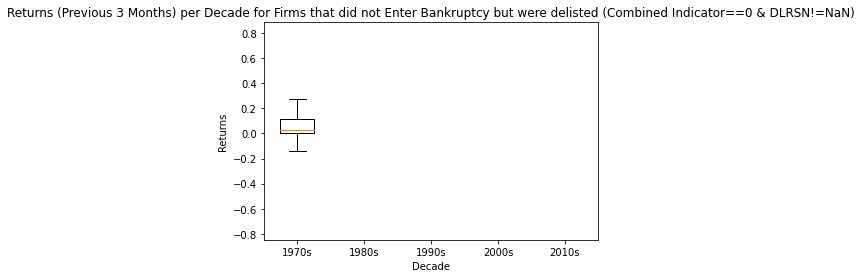

In [59]:
# Set Variables to Change
# Time Period Cuts
cut_labels = ['1970s', '1980s', '1990s', '2000s', '2010s']
cut_bins = [1970, 1979, 1989, 1999, 2009, 2019]
cut_column_label = 'Decade'

# Return
returnName='AvgReturn_prev3months'
returnTypeName='Returns'
bankruptcyIndicatorNameValue = 'Combined Indicator==0 & DLRSN!=NaN'

# Plot
plotTitle = f'{returnTypeName} (Previous 3 Months) per {cut_column_label} for Firms that did not Enter Bankruptcy but were delisted ({bankruptcyIndicatorNameValue})'

# Results
printResultsBool=False

# Copy DataFrame
bankruptFirmsPrevReturnsAnalysis = dfTest.copy()

plotReturns(bankruptFirmsPrevReturnsAnalysis,
                cut_labels,
                cut_bins,
                cut_column_label,
                returnName,
                returnTypeName,
                bankruptcyIndicatorNameValue,
                plotTitle,
            printResultsBool
                )

### Average Return Pervious 4 Months Before Delisting

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


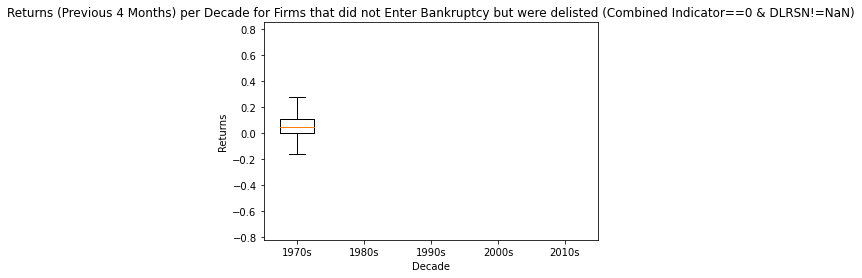

In [60]:
# Set Variables to Change
# Time Period Cuts
cut_labels = ['1970s', '1980s', '1990s', '2000s', '2010s']
cut_bins = [1970, 1979, 1989, 1999, 2009, 2019]
cut_column_label = 'Decade'

# Return
returnName='AvgReturn_prev4months'
returnTypeName='Returns'
bankruptcyIndicatorNameValue = 'Combined Indicator==0 & DLRSN!=NaN'

# Plot
plotTitle = f'{returnTypeName} (Previous 4 Months) per {cut_column_label} for Firms that did not Enter Bankruptcy but were delisted ({bankruptcyIndicatorNameValue})'

# Results
printResultsBool=False

# Copy DataFrame
bankruptFirmsPrevReturnsAnalysis = dfTest.copy()

plotReturns(bankruptFirmsPrevReturnsAnalysis,
                cut_labels,
                cut_bins,
                cut_column_label,
                returnName,
                returnTypeName,
                bankruptcyIndicatorNameValue,
                plotTitle,
            printResultsBool
                )

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/dis

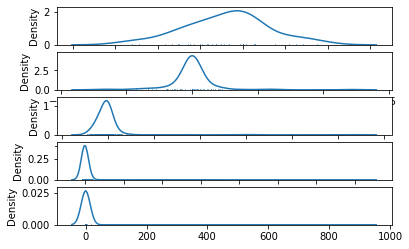

In [10]:
import seaborn as sns

fig, ax =plt.subplots(len(cut_labels),1)
for i, decade in enumerate(cut_labels):
  sns.distplot(tempStorage[i], hist=False, rug=True, ax=ax[i])



fig.show()

#sns.plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


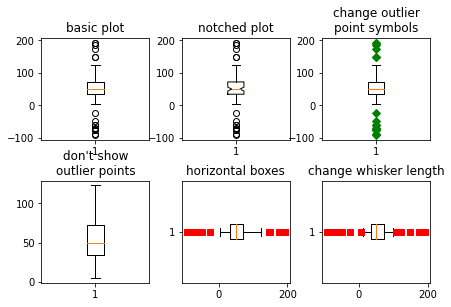

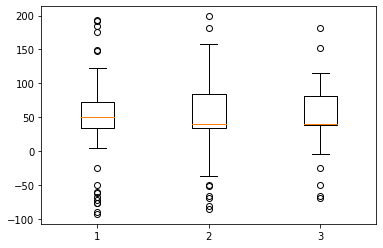

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon


# Fixing random state for reproducibility
np.random.seed(19680801)

# fake up some data
spread = np.random.rand(50) * 100
center = np.ones(25) * 50
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
data = np.concatenate((spread, center, flier_high, flier_low))

fig, axs = plt.subplots(2, 3)

# basic plot
axs[0, 0].boxplot(data)
axs[0, 0].set_title('basic plot')

# notched plot
axs[0, 1].boxplot(data, 1)
axs[0, 1].set_title('notched plot')

# change outlier point symbols
axs[0, 2].boxplot(data, 0, 'gD')
axs[0, 2].set_title('change outlier\npoint symbols')

# don't show outlier points
axs[1, 0].boxplot(data, 0, '')
axs[1, 0].set_title("don't show\noutlier points")

# horizontal boxes
axs[1, 1].boxplot(data, 0, 'rs', 0)
axs[1, 1].set_title('horizontal boxes')

# change whisker length
axs[1, 2].boxplot(data, 0, 'rs', 0, 0.75)
axs[1, 2].set_title('change whisker length')

fig.subplots_adjust(left=0.08, right=0.98, bottom=0.05, top=0.9,
                    hspace=0.4, wspace=0.3)

# fake up some more data
spread = np.random.rand(50) * 100
center = np.ones(25) * 40
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
d2 = np.concatenate((spread, center, flier_high, flier_low))
data.shape = (-1, 1)
d2.shape = (-1, 1)
# Making a 2-D array only works if all the columns are the
# same length.  If they are not, then use a list instead.
# This is actually more efficient because boxplot converts
# a 2-D array into a list of vectors internally anyway.
data = [data, d2, d2[::2, 0]]

# Multiple box plots on one Axes
fig, ax = plt.subplots()
ax.boxplot(data)

plt.show()

In [ ]:
d2[::2, 0]

array([ 83.78376368,  79.72347418,  14.80628764,  78.83733255,
        59.8496483 ,  72.30380198,  22.68103954,  84.79437532,
        95.60361846,  70.8324671 ,  35.37963854,  64.85338993,
        53.80093632,  52.09349339,  15.79803754,  78.42297751,
        15.46468315,  83.68309041,  57.67138189,  11.77939697,
        28.36723023,  90.94254614,  95.17655686,  87.43141503,
        75.03353804,  40.        ,  40.        ,  40.        ,
        40.        ,  40.        ,  40.        ,  40.        ,
        40.        ,  40.        ,  40.        ,  40.        ,
        40.        ,  40.        , 106.09770913, 181.25032132,
       115.02459814, 152.7059502 , 109.21899366,  -4.28311062,
       -24.21986649, -69.55898582, -50.57014395, -66.00845699])

In [ ]:
plot = False
if plot:
  # Convert Month Field to Year (int)
  dfTest['year'] = dfTest['date_month'].map(lambda x: int(str(x)[:4]))

  # Plot avg return Per Year
  test = dfTest.groupby(['PERMNO', 'date_month'])['RET2'].mean()
  test.reset_index().groupby('PERMNO').plot('date_month', 'RET2')

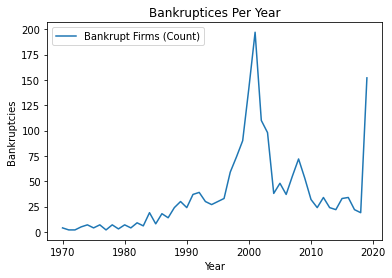

In [21]:
test3 = dfTest.copy()

# Convert Month Field to Year (int)
test3['year'] = test3['date_month'].map(lambda x: int(str(x)[:4]))

# Count number of bankruptcies Per Year
test3 = test3.groupby(['year'])['PERMNO'].count()

plt.plot(test3, label='Bankrupt Firms (Count)')
plt.xlabel("Year")
plt.ylabel("Bankruptcies")
plt.title('Bankruptices Per Year')
plt.legend()
plt.show()